In [ ]:
from transformers import AutoTokenizer,CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms,datasets, transforms
from tqdm import tqdm
from torch.utils.data._utils.collate import default_collate
from google.colab import drive
import tarfile
import tempfile
from PIL import Image
import os
import torch
import logging
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [ ]:
file_path = "/content/drive/My Drive/dlcv_final/correct.pt"
data = torch.load(file_path)

# Example: Accessing the first sample
print(f"Total Samples: {len(data)}")
first_sample = data[0]
print("First sample keys:", first_sample.keys())
print("Match label:", first_sample["match"])

<ipython-input-2-8694c3c4adfb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


Total Samples: 9815
First sample keys: dict_keys(['inputs', 'match'])
Match label: tensor([1.])


In [ ]:
print("First sample keys:", first_sample["inputs"].keys())

First sample keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask'])


In [ ]:
for sample in data:
    print(f"Pixel values: {sample['inputs']['pixel_values'].size()}")
    print(f"Input IDs: {sample['inputs']['input_ids'].size()}")
    print(f"Attention Mask: {sample['inputs']['attention_mask'].size()}")
    print(f"Match: {sample['match'].size()}")
    break

Pixel values: torch.Size([3, 3, 224, 224])
Input IDs: torch.Size([1, 30])
Attention Mask: torch.Size([1, 30])
Match: torch.Size([1])


In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    """
    Custom collate function to ensure consistent tensor shapes in batches, including dynamic padding for text sequences.
    """
    # Stack image tensors and ensure correct shape
    pixel_values = torch.stack([b["inputs"]["pixel_values"] for b in batch]).squeeze(1)  # Remove extra dimension if present

    # Pad text sequences to the maximum length in the batch
    input_ids = pad_sequence([b["inputs"]["input_ids"].squeeze(0) for b in batch], batch_first=True, padding_value=0)
    attention_mask = pad_sequence([b["inputs"]["attention_mask"].squeeze(0) for b in batch], batch_first=True, padding_value=0)

    # Concatenate match labels and ensure they have the correct shape
    matches = torch.cat([b["match"] for b in batch], dim=0).unsqueeze(1)

    return {
        "inputs": {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        },
        "match": matches
    }
def split_and_create_dataloaders(data, batch_size=32, train_split=0.8, val_split=0.1, test_split=0.1):
    """
    Splits the dataset into training, validation, and test sets, and creates DataLoaders.

    Args:
    - data: The full dataset to split.
    - batch_size: Batch size for DataLoaders.
    - train_split: Fraction of data for training.
    - val_split: Fraction of data for validation.
    - test_split: Fraction of data for testing.

    Returns:
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - test_loader: DataLoader for test data.
    """
    total_size = len(data)

    # Compute split sizes
    test_size = int(total_size * test_split)
    train_val_size = total_size - test_size
    val_size = int(train_val_size * val_split / (train_split + val_split))
    train_size = train_val_size - val_size

    # Split the dataset
    train_val_data, test_data = random_split(data, [train_val_size, test_size])
    train_data, val_data = random_split(train_val_data, [train_size, val_size])

    # Create DataLoaders with the custom collate_fn
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    print(f"Dataset split: {len(train_data)} training, {len(val_data)} validation, {len(test_data)} testing")
    return train_loader, val_loader, test_loader


In [ ]:
train_loader, val_loader, test_loader = split_and_create_dataloaders(data, batch_size=32)

Dataset split: 7853 training, 981 validation, 981 testing


# Model setup

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import torch
def validate_clip(model, processor, val_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(compatibility_scores.cpu().numpy())

    # Calculate AUC-ROC
    auc = roc_auc_score(all_labels, all_scores)
    print(f"Validation AUC-ROC: {auc}")
    return auc

def fine_tune_clip(model, processor, train_loader, val_loader, save_dir, epochs=5, lr=5e-5, patience=5):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_score = float('-inf')
    no_improvement_count = 0
    best_model_path = None

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            # Calculate loss
            loss = criterion(compatibility_scores, labels)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print training loss
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validate the model and compute average compatibility score
        avg_val_score = validate_clip(model, processor, val_loader)

        # Step the scheduler
        scheduler.step(avg_val_score)

        # Save the model if it's the best so far
        if avg_val_score > best_score:
            best_score = avg_val_score
            no_improvement_count = 0
            best_model_path = os.path.join(save_dir, f"correct_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with AUC-ROC: {best_score}")
        else:
            no_improvement_count += 1
            print(f"No improvement for {no_improvement_count} epoch(s). Best AUC-ROC remains: {best_score}")

        # Early stopping if no improvement for `patience` epochs
        if no_improvement_count >= patience:
            print("Early stopping triggered.")
            break

    return best_model_path

# Parameters
save_dir = "/content/drive/My Drive/dlcv_final/saved_models"
epochs = 100
lr = 1e-4
patience = 5

# Fine-tune the CLIP model
best_model_path = fine_tune_clip(model, processor, train_loader, val_loader, save_dir, epochs, lr, patience)

Epoch 1/100: 100%|██████████| 246/246 [27:34<00:00,  6.73s/it]


Epoch 1/100, Training Loss: 0.6941953916859821
Validation AUC-ROC: 0.5130934665680154
Best model saved at epoch 1 with AUC-ROC: 0.5130934665680154


Epoch 2/100: 100%|██████████| 246/246 [27:28<00:00,  6.70s/it]


Epoch 2/100, Training Loss: 0.6935736205035109
Validation AUC-ROC: 0.5088515990655837
No improvement for 1 epoch(s). Best AUC-ROC remains: 0.5130934665680154


Epoch 3/100: 100%|██████████| 246/246 [27:36<00:00,  6.73s/it]


Epoch 3/100, Training Loss: 0.6933894901256251
Validation AUC-ROC: 0.4641966430845713
No improvement for 2 epoch(s). Best AUC-ROC remains: 0.5130934665680154


Epoch 4/100: 100%|██████████| 246/246 [27:27<00:00,  6.70s/it]


Epoch 4/100, Training Loss: 0.692957017237578
Validation AUC-ROC: 0.493185162400552
No improvement for 3 epoch(s). Best AUC-ROC remains: 0.5130934665680154


Epoch 5/100: 100%|██████████| 246/246 [27:36<00:00,  6.73s/it]


Epoch 5/100, Training Loss: 0.6934002451295775
Validation AUC-ROC: 0.48408208564374133
No improvement for 4 epoch(s). Best AUC-ROC remains: 0.5130934665680154


Epoch 6/100:  13%|█▎        | 33/246 [03:50<24:45,  6.97s/it]


KeyboardInterrupt: 

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import torch

def validate_clip(model, processor, val_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(compatibility_scores.cpu().numpy())

    # Calculate AUC-ROC
    auc = roc_auc_score(all_labels, all_scores)
    print(f"Validation AUC-ROC: {auc}")
    return auc

def fine_tune_clip(model, processor, train_loader, val_loader, save_dir, epochs=20, lr=5e-6, patience=5):
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_score = float('-inf')
    no_improvement_count = 0
    best_model_path = None

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            # Calculate loss
            loss = criterion(compatibility_scores, labels)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Print training loss
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validate the model
        avg_val_score = validate_clip(model, processor, val_loader)

        # Step the scheduler
        scheduler.step(epoch + avg_val_score)

        # Save the model if it's the best so far
        if avg_val_score > best_score:
            best_score = avg_val_score
            no_improvement_count = 0
            best_model_path = os.path.join(save_dir, f"correct_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with AUC-ROC: {best_score}")
        else:
            no_improvement_count += 1
            print(f"No improvement for {no_improvement_count} epoch(s). Best AUC-ROC remains: {best_score}")

        # Early stopping if no improvement for `patience` epochs
        if no_improvement_count >= patience:
            print("Early stopping triggered.")
            break

    return best_model_path

save_dir = "/content/drive/My Drive/dlcv_final/saved_models"
best_model_path = fine_tune_clip(model, processor, train_loader, val_loader, save_dir)

Epoch 1/20: 100%|██████████| 246/246 [27:46<00:00,  6.77s/it]


Epoch 1/20, Training Loss: 0.674588554273776
Validation AUC-ROC: 0.7314259824256581
Best model saved at epoch 1 with AUC-ROC: 0.7314259824256581


Epoch 2/20: 100%|██████████| 246/246 [27:39<00:00,  6.75s/it]


Epoch 2/20, Training Loss: 0.6420488740370526
Validation AUC-ROC: 0.7609839636209462
Best model saved at epoch 2 with AUC-ROC: 0.7609839636209462


Epoch 3/20: 100%|██████████| 246/246 [27:51<00:00,  6.80s/it]


Epoch 3/20, Training Loss: 0.6278926870687221
Validation AUC-ROC: 0.7149199012378522
No improvement for 1 epoch(s). Best AUC-ROC remains: 0.7609839636209462


Epoch 4/20: 100%|██████████| 246/246 [27:52<00:00,  6.80s/it]


Epoch 4/20, Training Loss: 0.6154193085868184
Validation AUC-ROC: 0.7166823234044676
No improvement for 2 epoch(s). Best AUC-ROC remains: 0.7609839636209462


Epoch 5/20: 100%|██████████| 246/246 [27:45<00:00,  6.77s/it]


Epoch 5/20, Training Loss: 0.6020620811760911
Validation AUC-ROC: 0.684168959755256
No improvement for 3 epoch(s). Best AUC-ROC remains: 0.7609839636209462


Epoch 6/20: 100%|██████████| 246/246 [28:17<00:00,  6.90s/it]


Epoch 6/20, Training Loss: 0.5937568494459478
Validation AUC-ROC: 0.6847508916027234
No improvement for 4 epoch(s). Best AUC-ROC remains: 0.7609839636209462


Epoch 7/20: 100%|██████████| 246/246 [28:47<00:00,  7.02s/it]


Epoch 7/20, Training Loss: 0.6111268124929289
Validation AUC-ROC: 0.6821238849770137
No improvement for 5 epoch(s). Best AUC-ROC remains: 0.7609839636209462
Early stopping triggered.


In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
import torch

def freeze_layers(model, unfreeze_after_epoch, current_epoch):
    """
    Dynamically freezes or unfreezes the lower layers of the vision and text encoders
    based on the current epoch.
    """
    if current_epoch < unfreeze_after_epoch:
        # Freeze the lower layers of the vision encoder
        for param in model.vision_model.encoder.layers[:-4].parameters():
            param.requires_grad = False
        # Freeze the lower layers of the text encoder
        for param in model.text_model.encoder.layers[:-4].parameters():
            param.requires_grad = False
        print(f"Epoch {current_epoch}: Lower layers frozen.")
    else:
        # Unfreeze all layers after `unfreeze_after_epoch`
        for param in model.vision_model.parameters():
            param.requires_grad = True
        for param in model.text_model.parameters():
            param.requires_grad = True
        print(f"Epoch {current_epoch}: All layers unfrozen.")
def validate_clip(model, processor, val_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(compatibility_scores.cpu().numpy())

    # Calculate AUC-ROC
    auc = roc_auc_score(all_labels, all_scores)
    print(f"Validation AUC-ROC: {auc}")
    return auc


def fine_tune_clip(model, processor, train_loader, val_loader, save_dir, epochs=20, lr=5e-6, patience=5, unfreeze_after_epoch=3):
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_score = float('-inf')
    no_improvement_count = 0
    best_model_path = None

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(epochs):
        # Freeze or unfreeze layers dynamically
        freeze_layers(model, unfreeze_after_epoch, epoch)

        model.train()
        epoch_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            # Calculate loss
            loss = criterion(compatibility_scores, labels)
            epoch_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Print training loss
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validate the model
        avg_val_score = validate_clip(model, processor, val_loader)

        # Step the scheduler
        scheduler.step(epoch + avg_val_score)

        # Save the model if it's the best so far
        if avg_val_score > best_score:
            best_score = avg_val_score
            no_improvement_count = 0
            best_model_path = os.path.join(save_dir, f"frozen_correct_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with AUC-ROC: {best_score}")
        else:
            no_improvement_count += 1
            print(f"No improvement for {no_improvement_count} epoch(s). Best AUC-ROC remains: {best_score}")

        # Early stopping if no improvement for `patience` epochs
        if no_improvement_count >= patience:
            print("Early stopping triggered.")
            break

    return best_model_path

save_dir = "/content/drive/My Drive/dlcv_final/saved_models"
best_model_path = fine_tune_clip(model, processor, train_loader, val_loader, save_dir)

Epoch 0: Lower layers frozen.


Epoch 1/20: 100%|██████████| 246/246 [23:18<00:00,  5.68s/it]


Epoch 1/20, Training Loss: 0.6753298858316933
Validation AUC-ROC: 0.7190100507943371
Best model saved at epoch 1 with AUC-ROC: 0.7190100507943371
Epoch 1: Lower layers frozen.


Epoch 2/20: 100%|██████████| 246/246 [22:49<00:00,  5.57s/it]


Epoch 2/20, Training Loss: 0.646771901022128
Validation AUC-ROC: 0.753630839062591
Best model saved at epoch 2 with AUC-ROC: 0.753630839062591
Epoch 2: Lower layers frozen.


Epoch 3/20: 100%|██████████| 246/246 [22:19<00:00,  5.44s/it]


Epoch 3/20, Training Loss: 0.6333764995016703
Validation AUC-ROC: 0.7453175269559146
No improvement for 1 epoch(s). Best AUC-ROC remains: 0.753630839062591
Epoch 3: All layers unfrozen.


Epoch 4/20: 100%|██████████| 246/246 [28:06<00:00,  6.86s/it]


Epoch 4/20, Training Loss: 0.6244159709147321
Validation AUC-ROC: 0.7546118098911788
Best model saved at epoch 4 with AUC-ROC: 0.7546118098911788
Epoch 4: All layers unfrozen.


Epoch 5/20: 100%|██████████| 246/246 [27:48<00:00,  6.78s/it]


Epoch 5/20, Training Loss: 0.6180360196082573
Validation AUC-ROC: 0.748322789282478
No improvement for 1 epoch(s). Best AUC-ROC remains: 0.7546118098911788
Epoch 5: All layers unfrozen.


Epoch 6/20: 100%|██████████| 246/246 [27:48<00:00,  6.78s/it]


Epoch 6/20, Training Loss: 0.6153955556512848
Validation AUC-ROC: 0.7489171910981054
No improvement for 2 epoch(s). Best AUC-ROC remains: 0.7546118098911788
Epoch 6: All layers unfrozen.


Epoch 7/20: 100%|██████████| 246/246 [27:45<00:00,  6.77s/it]


Epoch 7/20, Training Loss: 0.6219630415846662
Validation AUC-ROC: 0.7393402555512142
No improvement for 3 epoch(s). Best AUC-ROC remains: 0.7546118098911788
Epoch 7: All layers unfrozen.


Epoch 8/20: 100%|██████████| 246/246 [27:37<00:00,  6.74s/it]


Epoch 8/20, Training Loss: 0.6160923586628302
Validation AUC-ROC: 0.6987546658464199
No improvement for 4 epoch(s). Best AUC-ROC remains: 0.7546118098911788
Epoch 8: All layers unfrozen.


Epoch 9/20: 100%|██████████| 246/246 [27:55<00:00,  6.81s/it]


Epoch 9/20, Training Loss: 0.6086365936732874
Validation AUC-ROC: 0.6914555778167579
No improvement for 5 epoch(s). Best AUC-ROC remains: 0.7546118098911788
Early stopping triggered.


In [ ]:
# Load the best model for further evaluation or inference
model.load_state_dict(torch.load(best_model_path))
print(f"Best model loaded from {best_model_path}")

# Model testing

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import matplotlib.pyplot as plt

def test_clip(model, processor, test_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        # for batch in tqdm(test_loader, desc="Testing"):
        for batch in test_loader:
            images = batch["inputs"]["pixel_values"]
            input_ids = batch["inputs"]["input_ids"]
            attention_mask = batch["inputs"]["attention_mask"]
            labels = batch["match"].float().squeeze(-1)

            # Reshape and repeat inputs for compatibility with CLIP model
            batch_size, num_images, channels, height, width = images.shape
            images = images.view(-1, channels, height, width)
            repeated_input_ids = input_ids.repeat_interleave(num_images, dim=0)
            repeated_attention_mask = attention_mask.repeat_interleave(num_images, dim=0)

            # Forward pass through the model
            outputs = model(
                pixel_values=images,
                input_ids=repeated_input_ids,
                attention_mask=repeated_attention_mask
            )
            text_embedding = outputs.text_embeds
            image_embedding = outputs.image_embeds

            # Aggregate embeddings
            image_embedding = image_embedding.view(batch_size, num_images, -1)
            aggregated_image_embedding = image_embedding.mean(dim=1)
            text_embedding = text_embedding.view(batch_size, num_images, -1)
            aggregated_text_embedding = text_embedding.mean(dim=1)

            # Normalize embeddings
            aggregated_text_embedding = torch.nn.functional.normalize(aggregated_text_embedding, p=2, dim=1)
            aggregated_image_embedding = torch.nn.functional.normalize(aggregated_image_embedding, p=2, dim=1)

            # Compute cosine similarity
            compatibility_scores = (aggregated_text_embedding * aggregated_image_embedding).sum(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(compatibility_scores.cpu().numpy())

    return all_labels, all_scores

    ''' # Calculate AUC-ROC
    auc = roc_auc_score(all_labels, all_scores)
    print(f"Validation AUC-ROC: {auc}")
    return auc '''



In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_auc_roc_curve(labels, scores):
    """
    Plot the ROC curve and calculate AUC-ROC.
    """
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC-ROC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


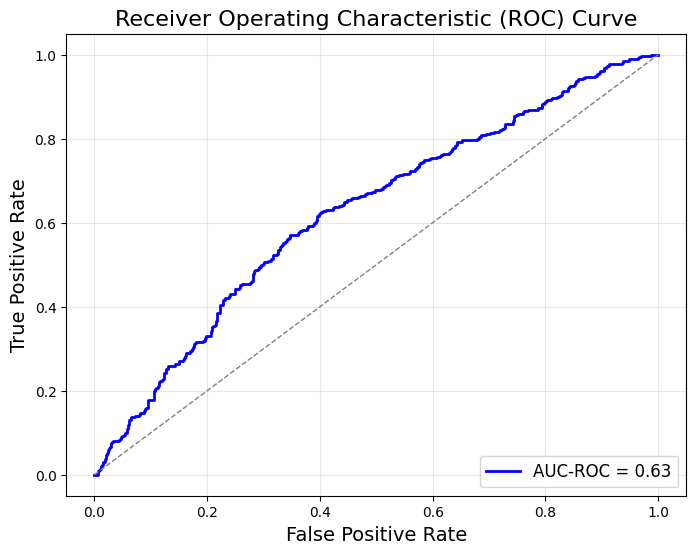

In [ ]:
# Test on pre-trained
pretrained_labels, pretrained_scores = test_clip(model, processor, test_loader)
plot_auc_roc_curve(pretrained_labels, pretrained_scores)

In [ ]:
# Test on new fine-tuned
best_model_path = "/content/drive/My Drive/dlcv_final/saved_models/frozen_correct_epoch_4.pt" # Replace with your best model path.
model.load_state_dict(torch.load(best_model_path))
test_labels, test_scores = test_clip(model, processor, test_loader)
plot_auc_roc_curve(test_labels, test_scores)

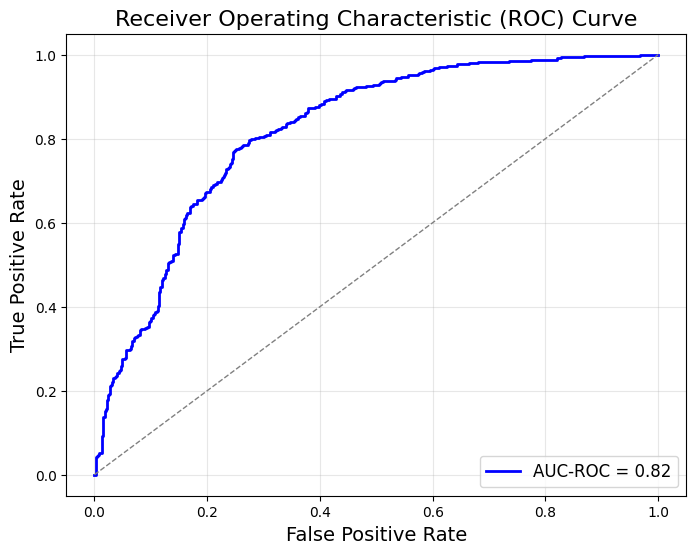

In [ ]:
plot_auc_roc_curve(test_labels, test_scores)

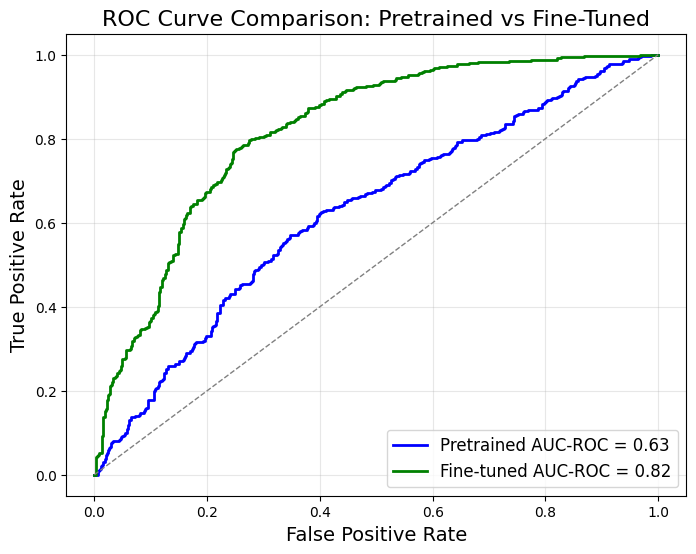

In [ ]:
# Comparison
plt.figure(figsize=(8, 6))

# Pretrained model
fpr_pretrained, tpr_pretrained, _ = roc_curve(pretrained_labels, pretrained_scores)
roc_auc_pretrained = auc(fpr_pretrained, tpr_pretrained)
plt.plot(fpr_pretrained, tpr_pretrained, color="blue", lw=2, label=f"Pretrained AUC-ROC = {roc_auc_pretrained:.2f}")

# Fine-tuned model
fpr_finetuned, tpr_finetuned, _ = roc_curve(test_labels, test_scores)
roc_auc_finetuned = auc(fpr_finetuned, tpr_finetuned)
plt.plot(fpr_finetuned, tpr_finetuned, color="green", lw=2, label=f"Fine-tuned AUC-ROC = {roc_auc_finetuned:.2f}")

# Plot settings
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Comparison: Pretrained vs Fine-Tuned", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# User Simulation

Sample 1 Text: a female outfit for workplace with a simple style , including a sweater ( top ), a skirt ( skirt ), a high heels ( shoes ). !!!


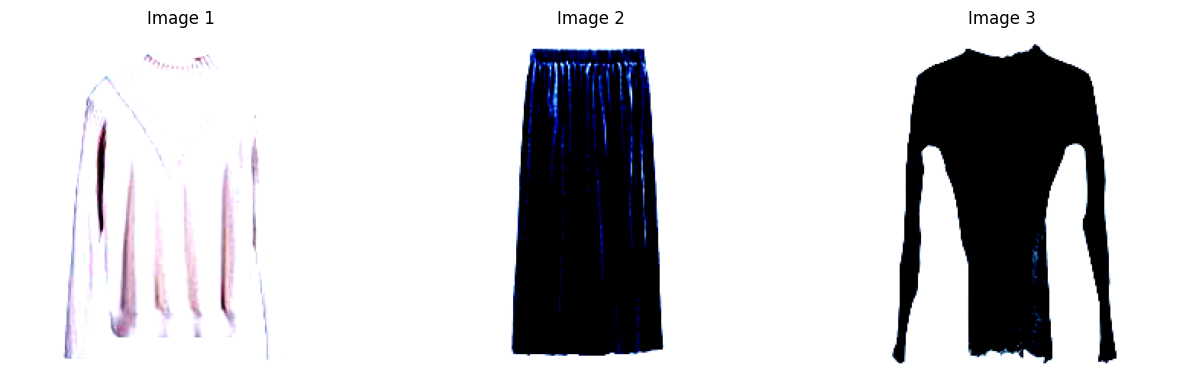

Sample 2 Text: a male outfit for party with a simple style , including a sweaters ( top ), a jeans ( pants ), a shoes ( shoes ). !!!!


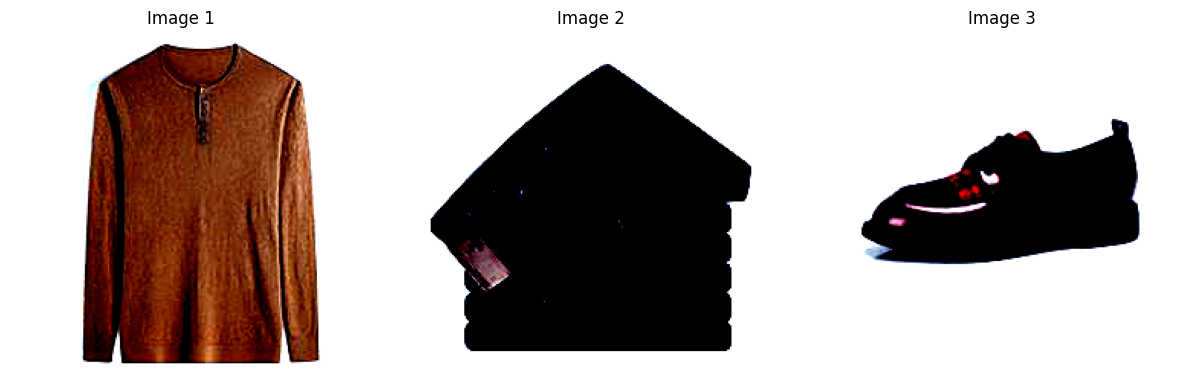

Sample 3 Text: a male outfit for workplace with a simple style , including a sweater ( top ), a dress pants ( pants ), a ( shoes ). !!!!


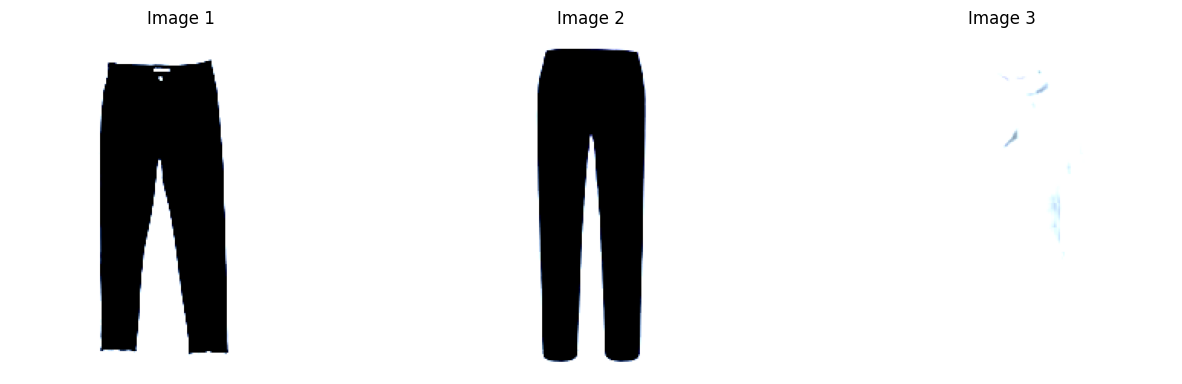

In [ ]:
import matplotlib.pyplot as plt

# Function to display images and corresponding text from the DataLoader
def display_images_and_text_from_loader(loader, processor, num_samples=3, num_images=3):
    """
    Display images and corresponding text from the DataLoader.

    Args:
    - loader: DataLoader object (e.g., test_loader).
    - processor: The CLIP processor used for tokenizing the text (to decode input_ids).
    - num_samples: Number of samples to display.
    - num_images: Number of images to display per sample.
    """
    # Get a batch from the loader
    batch = next(iter(loader))  # Get the first batch
    pixel_values = batch["inputs"]["pixel_values"]  # Extract image tensors
    input_ids = batch["inputs"]["input_ids"]  # Extract text token IDs

    # Plot each sample
    for sample_idx in range(min(num_samples, pixel_values.size(0))):  # Limit to available samples
        images = pixel_values[sample_idx]  # Shape: [num_images, C, H, W]
        text_ids = input_ids[sample_idx]  # Token IDs for this sample

        # Decode the text for the sample
        text = processor.tokenizer.decode(text_ids.squeeze(0), skip_special_tokens=True)

        # Display text
        print(f"Sample {sample_idx + 1} Text: {text}")

# Call the function to display images and text
display_images_and_text_from_loader(test_loader, processor, num_samples=3, num_images=3)


In [ ]:
# Load JSON file
import json
with open("/content/drive/My Drive/dlcv_final/test_1_positive.json", "r") as file:
    outfits = json.load(file)

In [ ]:
import random,re
import difflib


def simulate_user(outfits, test_loader, index):
  """
  Simulate a user query by decoding a description and selecting a matching outfit.
  Ensures non-matching items differ in subcategory, gender, style, or location but share the same category.

  Args:
  - outfits: List of all outfits.
  - test_loader: DataLoader containing test data.
  - index: Index position in test_loader to decode.

  Returns:
  - simulated_items: Dictionary of matching and non-matching items (keyed by category).
  - description: The description of the matching outfit.
  - matching_items: Dictionary of matching items (keyed by category).
  """
  # Decode the description from test_loader at the given index
  batch = next(iter(test_loader))  # Get the first batch
  description_ids = batch["inputs"]["input_ids"][index]  # Decode specific index
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
  raw_description = processor.tokenizer.decode(description_ids, skip_special_tokens=True)

  # Clean the decoded description
  description = re.sub(r"\(\s+", "(", raw_description)  # Remove space only after '('
  description = re.sub(r"\s*\)\s*", ")", description)  # Remove spaces before/after ')'
  description = description.replace("!", "")  # Remove '!' symbols
  description = re.sub(r"style\s*,", "style,", description)  # Remove space between "style" and ","
  description = description.strip()  # Clean trailing spaces
  description = re.sub(r"t\s*-\s*shirt", "t-shirt", description, flags=re.IGNORECASE)

  # Find the matching outfit in outfits based on the decoded description
  matching_outfit = next(
      (outfit for outfit in outfits if outfit["description"].lower() == description.lower()),
      None
  )

  if not matching_outfit:
      raise ValueError(f"No matching outfit found for description: {description}")

  description = description.split(",")[0]

  # Create a dictionary of matching items
  matching_items = {item["category"][0]: item for item in matching_outfit["Items"]}

  # Generate a non-matching item for each category in the outfit
  simulated_items = {}
  for category, matching_item in matching_items.items():
      # Find items with the same category across all outfits
      same_category_items = [
          (item, outfit)
          for outfit in outfits
          for item in outfit["Items"]
          if item["category"][0] == category
      ]

      # print(f"\nCategory: {category}")
      # print(f"Matching item: {matching_item}")

      # Filter non-matching items
      filtered_non_matching_items = []
      for item, outfit in same_category_items:
          # print(f"Checking item: {item}")
          if (
              matching_item["subcategory"] and item["subcategory"] and  # Ensure subcategories are not empty
              item["subcategory"][0] != matching_item["subcategory"][0] and
              # outfit["Outfit_Gender"] != matching_outfit["Outfit_Gender"] and
              outfit["Outfit_Occasion"] != matching_outfit["Outfit_Occasion"] and
              outfit["Outfit_Style"] != matching_outfit["Outfit_Style"]
          ):  # Check if subcategories, gender, occasion, or style differ
              # print("-> Added to non-matching items (differs in subcategory, gender, occasion, or style).")
              filtered_non_matching_items.append(item)
          # else:
              # print("-> Skipped (too similar).")

      if not filtered_non_matching_items:
          raise ValueError(f"No suitable non-matching items found for category: {category}")

      # Select a random non-matching item from the filtered list
      non_matching_item = random.choice(filtered_non_matching_items)

      # Store both matching and non-matching items in the simulated_items dictionary
      simulated_items[category] = {
          "matching": matching_item,
          "non_matching": non_matching_item
      }

  return simulated_items, description, matching_items


In [ ]:
def evaluate_outfit(model, processor, simulated_items, description, tar_paths, ground_truth):
    """
    Evaluate outfit compatibility using a CLIP model, ensuring one item per category.

    Args:
    - model: The CLIP model to evaluate.
    - processor: The CLIP processor for preprocessing inputs.
    - simulated_items: Dictionary with categories as keys and items as values.
    - description: Text description to evaluate.
    - tar_paths: List of paths to the .tar.gz files containing images.
    - ground_truth: List of ground truth items (dicts with "Image" keys).

    Returns:
    - best_combination: Indices of the best combination of items (keyed by category).
    - best_score: Compatibility score of the best combination.
    - is_correct: Boolean indicating whether the best combination matches the ground truth indices.
    """
    def extract_image(image_name, tar_paths):
        image_last_section = image_name.split("_")[-1]
        for tar_path in tar_paths:
            with tarfile.open(tar_path, "r:gz") as tar:
                try:
                    image_member = next(
                        (m for m in tar.getmembers()
                         if os.path.basename(m.name).split("_")[-1] == image_last_section),
                        None
                    )
                    if image_member:
                        temp_dir = tempfile.mkdtemp()  # Temporary directory to extract
                        tar.extract(image_member, path=temp_dir)
                        extracted_path = os.path.join(temp_dir, image_member.name)
                        return extracted_path
                except StopIteration:
                    continue
        return None  # Return None if the image is not found

    # Prepare images and text
    extracted_images = []
    category_items = {}
    for category, items in simulated_items.items():
        best_item = None
        best_score = -float('inf')

        for item_type, item in items.items():
            image_name = item["Image"]
            extracted_path = extract_image(image_name, tar_paths)
            if extracted_path is None:
                continue
            image = Image.open(extracted_path).convert("RGB")
            inputs = processor(
                text=[description],
                images=[image],
                return_tensors="pt",
                padding=True,
            )

            # Pass inputs through the model to get embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                text_embedding = outputs.text_embeds
                image_embedding = outputs.image_embeds

                # Normalize embeddings
                text_embedding = torch.nn.functional.normalize(text_embedding, p=2, dim=1)
                image_embedding = torch.nn.functional.normalize(image_embedding, p=2, dim=1)

                # Compute cosine similarity
                similarity = (text_embedding * image_embedding).sum().item()
                if similarity > best_score:
                    best_score = similarity
                    best_item = item

        if best_item is None:
            return None, None, False  # Skip if no valid item found in this category

        category_items[category] = best_item

    # Combine selected items into a single list
    final_items = list(category_items.values())
    extracted_images = [Image.open(extract_image(item["Image"], tar_paths)).convert("RGB") for item in final_items]

    # Prepare inputs for the final evaluation
    inputs = processor(
        text=[description] * len(extracted_images),
        images=extracted_images,
        return_tensors="pt",
        padding=True,
    )

    with torch.no_grad():
        outputs = model(**inputs)
        text_embeddings = outputs.text_embeds
        image_embeddings = outputs.image_embeds

        # Normalize embeddings
        text_embeddings = torch.nn.functional.normalize(text_embeddings, p=2, dim=1)
        image_embeddings = torch.nn.functional.normalize(image_embeddings, p=2, dim=1)

        # Compute cosine similarity for aggregated embeddings
        compatibility_scores = (text_embeddings * image_embeddings).sum(dim=1)
        best_score = compatibility_scores.mean().item()  # Aggregate by averaging

    is_correct = set(item["Image"] for item in final_items) == set(gt["Image"] for gt in ground_truth.values())

    return category_items, best_score, is_correct


In [ ]:
# User simulation
best_model_path = "/content/drive/My Drive/dlcv_final/saved_models/item_reduced_epoch_33.pt" # Replace with your best model path.
model.load_state_dict(torch.load(best_model_path))
tar_paths =  ["/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Validation.tar.gz","/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Test.tar.gz","/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Train.tar.gz"]
simulated_items, description, ground_truth = simulate_user(outfits,test_loader,0)
best_combination, best_score, is_correct = evaluate_outfit(model, processor, simulated_items, description,tar_paths,ground_truth)

<ipython-input-17-682d2d04b6f9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
# Output results
print("Inquiry Description:", description)

# Print simulated items as a dictionary of categories
print("Simulated Items (Images):", {category: {key: item["Image"] for key, item in items.items()} for category, items in simulated_items.items()})

# Print ground truth as a dictionary of categories
print("Ground Truth (Matching Items):", {category: item["Image"] for category, item in ground_truth.items()})

# Print best combination as a dictionary of categories
print("Best Combination (Indices):", {category: item["Image"] for category, item in best_combination.items()})

print("Best Score:", best_score)
print("Is Correct:", is_correct)


Inquiry Description: a female outfit for dating with a elegant style
Simulated Items (Images): {'Top': {'matching': '13844_9706_32902100139.jpg', 'non_matching': '10022_9715_15714205302.jpg'}, 'Skirt': {'matching': '13844_9719_33517483801.jpg', 'non_matching': '3463_9720_22763032100.jpg'}, 'Shoes': {'matching': '10423_1356_32896545877.jpg', 'non_matching': '7312_6914_29675191180.jpg'}}
Ground Truth (Matching Items): {'Top': '13844_9706_32902100139.jpg', 'Skirt': '13844_9719_33517483801.jpg', 'Shoes': '10423_1356_32896545877.jpg'}
Best Combination (Indices): {'Top': '13844_9706_32902100139.jpg', 'Skirt': '13844_9719_33517483801.jpg', 'Shoes': '7312_6914_29675191180.jpg'}
Best Score: -0.8669090270996094
Is Correct: False


In [ ]:
import random

def evaluate_test_loader(test_loader, outfits, model, processor, tar_paths, num):
    """
    Randomly pick `num` samples from test_loader, simulate user input, and evaluate outfit compatibility.

    Args:
    - test_loader: DataLoader containing test samples.
    - outfits: List of outfits for simulation.
    - model: CLIP model for evaluation.
    - processor: CLIP processor for handling text and images.
    - tar_paths: List of paths to tar.gz files containing images.
    - num: Number of valid samples to test.

    Returns:
    - results: List of dictionaries containing evaluation results for each sample.
    """
    results = []
    all_samples = [(batch_idx, sample_idx) for batch_idx, batch in enumerate(test_loader) for sample_idx in range(len(batch["inputs"]["input_ids"]))]

    if len(all_samples) < num:
        raise ValueError(f"Not enough samples in test_loader. Requested: {num}, Available: {len(all_samples)}")

    processed_samples = set()
    attempts = 0

    while len(results) < num:
        # Select a random sample
        batch_idx, sample_idx = random.choice(all_samples)

        # Avoid processing the same sample multiple times
        if (batch_idx, sample_idx) in processed_samples:
            continue

        processed_samples.add((batch_idx, sample_idx))

        # Load the corresponding batch
        batch = list(test_loader)[batch_idx]

        # Decode description from the current sample
        description_ids = batch["inputs"]["input_ids"][sample_idx]
        description = processor.tokenizer.decode(description_ids, skip_special_tokens=True)

        # Simulate user input
        try:
            simulated_items, cleaned_description, ground_truth = simulate_user(outfits, test_loader, sample_idx)
        except ValueError as e:
            # print(f"Skipping due to error: {e}")
            continue

        # Evaluate the outfit using the model
        best_combination, best_score, is_correct = evaluate_outfit(
            model, processor, simulated_items, cleaned_description, tar_paths, ground_truth
        )

        # Skip iteration if evaluation failed
        if best_combination is None:
            # print("Skipping due to missing images.")
            continue

        # Store the results
        results.append({
            "description": cleaned_description,
            "simulated_items": {
                category: {
                    key: item["Image"]
                    for key, item in items.items()
                }
                for category, items in simulated_items.items()
            },
            "ground_truth": {category: item["Image"] for category, item in ground_truth.items()},
            "best_combination": {category: item["Image"] for category, item in best_combination.items()},
            "best_score": best_score,
            "is_correct": is_correct
        })

        # Safeguard against infinite loops
        attempts += 1
        if attempts > len(all_samples):
            print("Not enough valid samples to meet the required count.")
            break

    # Summary report
    correct_matches = sum(result["is_correct"] for result in results)
    total_samples = len(results)
    print(f"Total Valid Samples: {total_samples}")
    print(f"Total Correct Matches: {correct_matches}/{total_samples}")
    print(f"Accuracy: {correct_matches / total_samples:.2%}" if total_samples > 0 else "Accuracy: N/A")

    return results


In [ ]:
# Load model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Test on pretrained model
results = evaluate_test_loader(test_loader, outfits, model, processor,tar_paths,num=50)

Total Valid Samples: 50
Total Correct Matches: 10/50
Accuracy: 20.00%


In [ ]:
tar_paths =  ["/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Validation.tar.gz","/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Test.tar.gz","/content/drive/My Drive/dlcv_final/images/Theme_Outfits_Train.tar.gz"]

best_model_path = "/content/drive/My Drive/dlcv_final/saved_models/frozen_correct_epoch_4.pt" # Replace with your best model path.
model.load_state_dict(torch.load(best_model_path))
results = evaluate_test_loader(test_loader, outfits, model, processor,tar_paths,num=50)

<ipython-input-22-48d2b3d14ea1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Total Valid Samples: 50
Total Correct Matches: 19/50
Accuracy: 38.00%


# Outfit Generation

In [ ]:
# Resizing
import os
from PIL import Image

def resize_images(input_folder, output_folder, size=(224, 224)):
    """
    Resizes all images in the input folder to the specified size and saves them to the output folder.

    Parameters:
        input_folder (str): Path to the folder containing the images to resize.
        output_folder (str): Path to the folder where resized images will be saved.
        size (tuple): Target size for resizing (width, height).
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        try:
            # Open the image and resize it
            with Image.open(input_path) as img:
                resized_img = img.resize(size)
                resized_img.save(output_path)
                print(f"Resized and saved: {filename}")
        except Exception as e:
            print(f"Could not process {filename}: {e}")

# Example usage
input_folder = "/content/drive/My Drive/dlcv_final/test"
output_folder = "/content/drive/My Drive/dlcv_final/test/resized"
resize_images(input_folder, output_folder)

Resized and saved: bot_1.png
Resized and saved: bot_2.png
Resized and saved: shoes_1.png
Resized and saved: top_2.png
Resized and saved: top_1.png
Could not process resized: [Errno 21] Is a directory: '/content/drive/My Drive/dlcv_final/test/resized'
Resized and saved: shoes_2.png


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch

def deploy_outfit_selection(model, processor, description, image_folder):
    """
    Selects one image per category based on the compatibility score with the given description.

    Args:
    - model: The CLIP model to use.
    - processor: The CLIP processor for preprocessing inputs.
    - description: Text description for selecting images.
    - image_folder: Path to the folder containing categorized images.

    Returns:
    - selected_items: Dictionary with categories as keys and selected image paths as values.
    - final_score: Compatibility score for the selected combination.
    """
    # Prepare categories from the image folder
    category_items = {}
    for filename in os.listdir(image_folder):
        if filename.endswith((".jpg", ".png")):
            category = filename.split("_")[0]
            if category not in category_items:
                category_items[category] = []
            category_items[category].append(os.path.join(image_folder, filename))

    # Select the best image for each category
    selected_items = {}
    final_images = []
    for category, image_paths in category_items.items():
        best_score = -float('inf')
        best_image_path = None

        for image_path in image_paths:
            image = Image.open(image_path).convert("RGB")
            inputs = processor(
                text=[description],
                images=[image],
                return_tensors="pt",
                padding=True,
            )

            # Pass inputs through the model
            with torch.no_grad():
                outputs = model(**inputs)
                text_embedding = outputs.text_embeds
                image_embedding = outputs.image_embeds

                # Normalize embeddings
                text_embedding = torch.nn.functional.normalize(text_embedding, p=2, dim=1)
                image_embedding = torch.nn.functional.normalize(image_embedding, p=2, dim=1)

                # Compute cosine similarity
                similarity = (text_embedding * image_embedding).sum().item()
                if similarity > best_score:
                    best_score = similarity
                    best_image_path = image_path

        # Add the best image for the category
        if best_image_path:
            selected_items[category] = best_image_path
            final_images.append(Image.open(best_image_path))

    # Plot the selected images
    plt.figure(figsize=(15, 5))
    for idx, (category, image_path) in enumerate(selected_items.items()):
        image = Image.open(image_path)
        plt.subplot(1, len(selected_items), idx + 1)
        plt.imshow(image)
        plt.title(category)
        plt.axis("off")
    plt.show()

    return selected_items


In [ ]:
# Meodel setup
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
best_model_path = "/content/drive/My Drive/dlcv_final/saved_models/frozen_correct_epoch_4.pt" # Replace with your best model path.
model.load_state_dict(torch.load(best_model_path))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

<ipython-input-4-384afab37686>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
description = "a male outfit for campus with a sporty style"
image_folder = "/content/drive/My Drive/dlcv_final/test/resized"

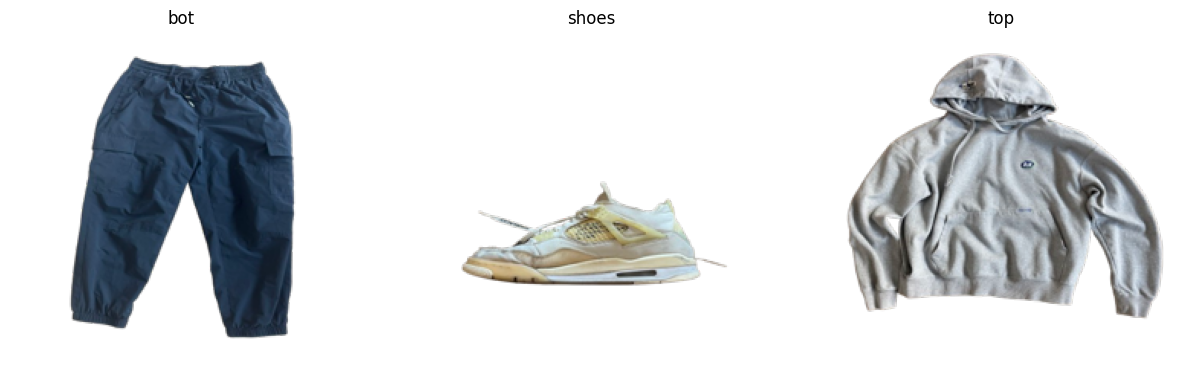

Selected Items: {'bot': '/content/drive/My Drive/dlcv_final/test/resized/bot_2.png', 'shoes': '/content/drive/My Drive/dlcv_final/test/resized/shoes_1.png', 'top': '/content/drive/My Drive/dlcv_final/test/resized/top_2.png'}


In [ ]:
selected_items = deploy_outfit_selection(model, processor, description, image_folder)
description = "a male outfit for campus with a sporty style"
print("Selected Items:", selected_items)